# # Exercise 1.1

## Classification of MNIST digits with a fully-connected neural network

In this exercise we will classify [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) using a fully-connected neural network

We start by importing the modules that we need

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We check that we have a GPU available

In [2]:
if torch.backends.mps.is_available():
    print("The code will run on GPU (mps).")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')  

The code will run on GPU (mps).


The MNIST dataset is a built-in dataset in PyTorch (it is a very common dataset to test algorithms on). 

We import it, and set our minibatch size

In [3]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

First, we plot the images to get an idea of what data we're working with. MNIST images are $28\times28$ images of handwritten digits (0-9)

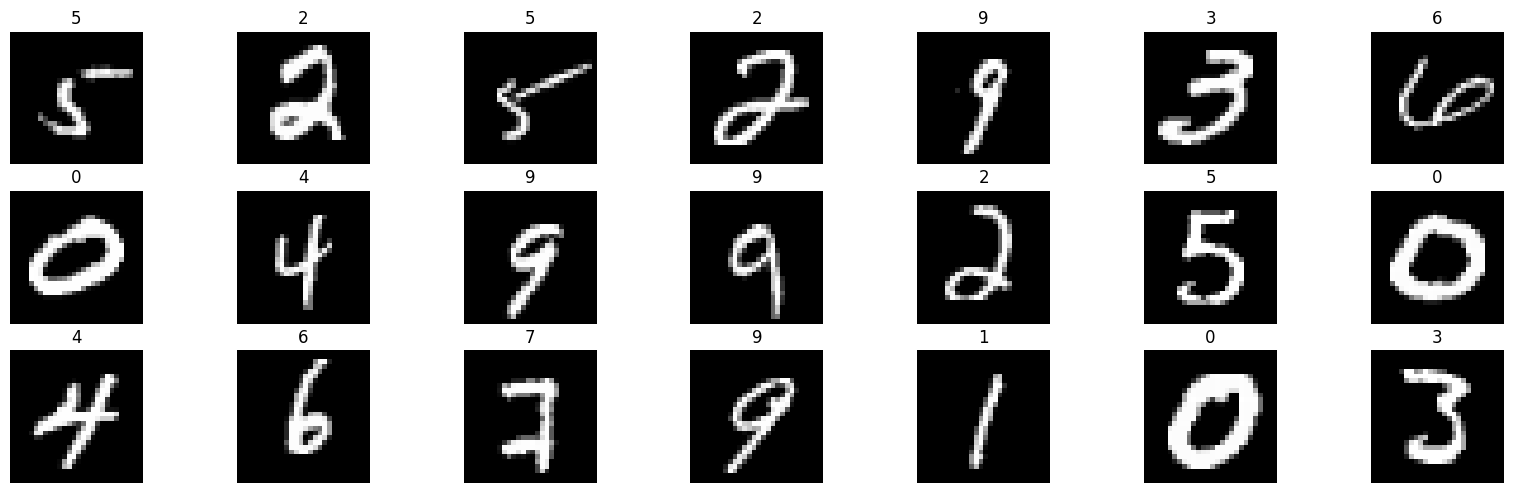

In [4]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

In [5]:
print(images[0].size())

torch.Size([1, 28, 28])


In [6]:
28 **2 

784

You should implement a fully-connected network to classify the digits. It should contain 1 hidden layer with 100 units. Don't forget the ReLU activation function after the hidden layer. 

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fully_connected1 = nn.Sequential(
            nn.Linear(784,100),
            nn.Sigmoid() # nn.ReLU()
            )
        self.fully_connected2 = nn.Sequential(
            nn.Linear(100,10),
            nn.Softmax(dim = 1)
            )
        
    def forward(self, x):
      #reshaping x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0),-1)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        return x

We instantiate a copy of our network and transfer it to the GPU if it's available

In [8]:
model = Network()
model.to(device)
#Initialize the optimer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

We train the network for five epochs

In [9]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0

    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()

        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 76.9%	 test: 89.2%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 89.7%	 test: 90.8%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 90.9%	 test: 91.7%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 91.8%	 test: 92.5%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 92.4%	 test: 92.9%


You should now have a model that has about 96% accuracy on the test set.
Try to get an even better accuracy. You can
* Change the number of hidden layers (initially=1, 2 => 97.6%, 3 => 97.5%)
* Change the number of units in the hidden layers (initially=100, 300 => 96.9% )
* Try changing the learning rate by factors of 10 (initially=0.1). What happens if it is too high or too low? Reducing it by a factor of 10 results in 91.5% and the network learn too slowly then more epochs are needed. To increase it be a factor of 10 results in 97.8% so I guess it worked out but it feels like a too high lr.
* Try using sigmoid instead of ReLU activation. What happens? It acheives a smaller acurracy.

How large accuracy can you get? The best accuracy was 97.8%

Try showing the classification output (probabilities) from the model alongside the ground truth.

* Which are classified correctly/incorrectly? 5 as 6, 6 as 0, 7 as 1, 1 as 7, 2 as 7, 9 as 7, 4 as 9 etc.
* If it's incorrect, what is the second most likely class? Usually the correct one. 
* Do the misclassifications you see make sense? Why/why not? Yes, very much

In [10]:
len(test_loader)

157

In [11]:
64*156+16

10000

In [12]:
labels = torch.empty(10000)
preds = torch.empty(10000)
probs = torch.empty((10000,10))
images = torch.empty((10000, 1, 28, 28))

for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        with torch.no_grad():
                output = model(data)
        preds[i*64: (i+1)*64] = output.argmax(1).cpu()
        labels[i*64: (i+1)*64] = target
        probs[i*64: (i+1)*64] = output
        images[i*64: (i+1)*64] = data
                

In [13]:
indexes = ~(preds == labels)
misclassified_images = images[indexes]
misclassified_probs, misclassified_classes = probs[indexes].sort(descending=True)
misclassified_labels = labels[indexes]
misclassified_preds = preds[indexes]

In [14]:
second_probs, second_class =  misclassified_probs[:,1], misclassified_classes[:,1]

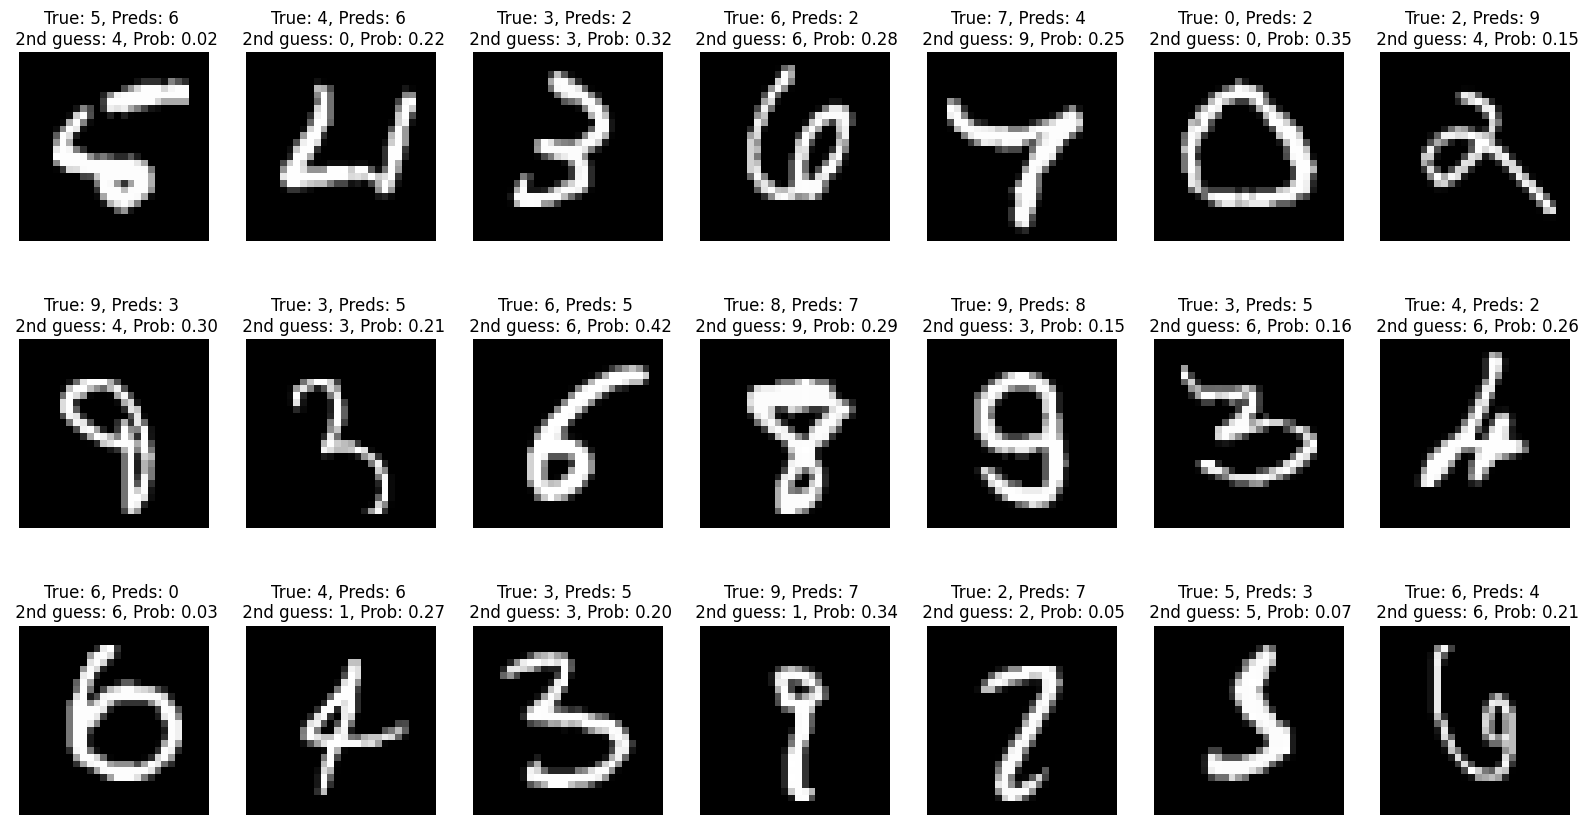

In [15]:
plt.figure(figsize=(20,18))
for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(misclassified_images[i].numpy()[0], 'gray')
    plt.title(f'True: {int(misclassified_labels[i])}, Preds: {(int(misclassified_preds[i]))} \n 2nd guess: {second_class[i]}, Prob: {second_probs[i]:.2f}')
    plt.axis('off')